# **Segmentación de mineria ilegal haciendo uso de Yolov8** **⛏**

---

### **Integrantes:**

- Kevin Santiago Artunduaga Vivas - 2216155
- Angie Patricia Manzano - 2216154


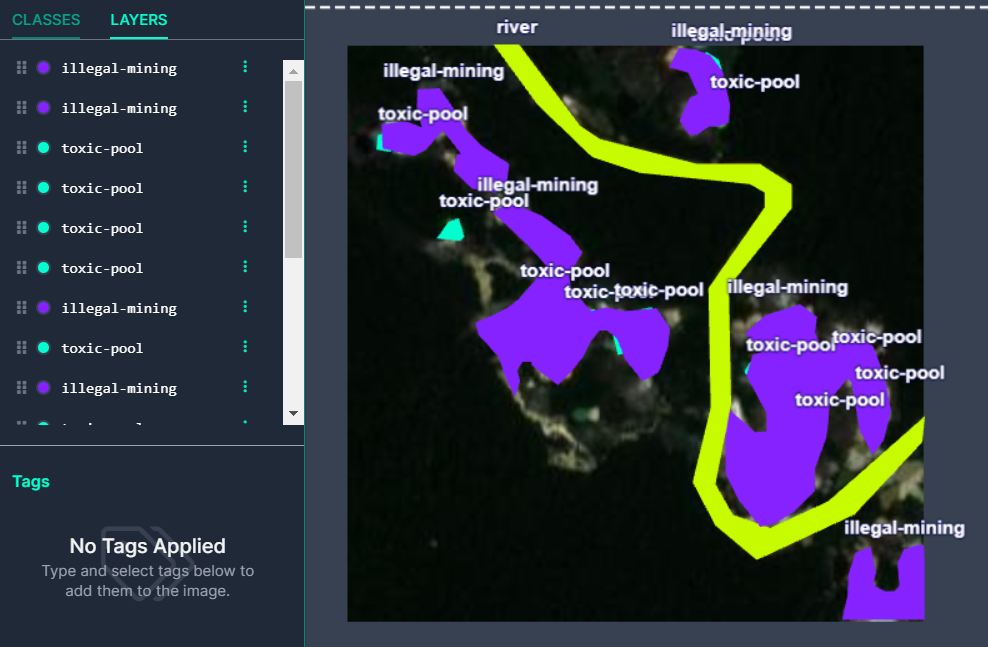

## **Dataset AmazonCRIME 2022**

Este es un conjunto de datos de Inteligencia Artificial Geoespacial y punto de referencia para la clasificación de áreas potenciales vinculadas a crímenes ambientales transnacionales en la selva amazónica.

Entre estas clases estan:

- Pistas de aterrizaje
- Deforestación
- Forestación
- **Mineria ilegal**
- Cultivos ilicitos
- Agua

Este dataset contaba con 5000 imagenes a partir de la mineria ilegal, sin embargo al contar con demasiadas imagenes se hizo la anotacion o labeling de 1053 imagenes, con las distintas clases:

| Clase | Descripción |
|-----------|-----------|
| illegal-mining | Área donde se realizan actividades de minería ilegal. |
| toxic-pool | Una piscina tóxica es el agua contaminada con productos químicos o desechos industriales por la mineria. |
| river | Avistamientos de rios o lagos cercas. |

`!nvidia-smi` proporciona una instantánea rápida y actualizada del estado de las GPUs NVIDIA en el sistema, lo que puede ser útil para monitorear el rendimiento de la GPU, indicandos que tenemos acceso al uso de la GPU.

In [1]:
!nvidia-smi

Thu May 30 23:02:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **Yolov8** 👀

YOLOv8, acrónimo de "You Only Look Once" (Solo miras una vez), es una familia de arquitecturas de redes neuronales convolucionales (CNN) diseñadas para la detección de objetos en tiempo real. Se destaca por su velocidad y precisión, lo que la convierte en una opción popular para una amplia gama de aplicaciones.

El proceso de detección de objetos en YOLOv8 se puede dividir en cuatro etapas principales:

1. Extracción de características: La imagen de entrada se pasa a través de una red neuronal convolucional profunda, que extrae características de alto nivel de la imagen.


2. Predicción de la cuadrícula: La red predice una cuadrícula de celdas que cubre la imagen de entrada. Cada celda corresponde a una región específica de la imagen.


3. Predicción de cajas delimitadoras y clases: Para cada celda, la red predice una caja delimitadora que rodea el objeto detectado en esa región, así como la clase del objeto (por ejemplo, persona, automóvil, bicicleta).


4. Supresión de no maximización: Se aplica un algoritmo de supresión de no maximización (NMS) para eliminar detecciones redundantes y seleccionar la mejor caja delimitadora para cada objeto.

Aqui se hace la instalacion de el modelo de Yolov8, y gracias a que esta se permite instalar con pip se hizo uso de la primera version del paquete oficial de Yolo

In [2]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.0/78.2 GB disk)


Ya posteriormente se importan las librerías, se carga un modelo preentrenado de YOLO de Ultralytics y se usa IPython.display para poder mostrar imagenes dentro del entorno de colab.

In [3]:
from ultralytics import YOLO
from IPython.display import display, Image

## **Roboflow**

Roboflow es una plataforma de software que facilita la creación y el uso de modelos de visión por computadora. Proporciona una suite de herramientas que abarca todo el proceso, desde la anotación de imágenes y videos hasta el entrenamiento e implementación de modelos. Roboflow está diseñado para ser fácil de usar, incluso para aquellos con poca o ninguna experiencia en visión por computadora.

Para ello primero tuvimos que hacer la carga de las imagenes, para posterior a ello comenzar con el etiquetado de las clases, luego de esto se movio al dataset y splitearon o dividieron en 3 partes:

- Train 86%: 1977 imagenes.
- Valid 9%: 211 imagenes.
- Test 5%: 104 imagenes.

Para el **preprocesado** se aplico:

1. **Auto-Orient:** Elimina los datos EXIF de las imágenes para garantizar la coherencia en la orientación de los datos.

2. **Data augmentation (90° Rotate Clockwise, Counter-Clockwise):** consiste en rotar las imágenes 90 grados, ya sea en el sentido de las agujas del reloj (Clockwise) o en sentido contrario a las agujas del reloj (Counter-Clockwise). Esto se hace para aumentar la diversidad del conjunto de datos de entrenamiento, mejorando así la capacidad del modelo para generalizar a nuevas imágenes.

El siguiente bloque configura la conexión con la plataforma Roboflow, accede a el proyecto llamado "segmentation illegal mining", el cual obtiene la segunda versión de ese proyecto y descarga el conjunto de datos asociado a esa versión en el formato YOLOv8, la plataforma contaba con 2 versiones Yolov5 y Yolov8.

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uT34YcGElTH0CbohbOXP")
project = rf.workspace("datamining-xn9jw").project("segmentation-illegal-mining")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


Este bloque de código utiliza Ultralytics y su comando `!yolo` para entrenar el modelo con YOLOv8 durante 100 épocas haciendo uso de la tarea de segmentacion, utilizando las imágenes con un tamaño de 256x256 píxeles, y generando gráficos de entrenamiento para monitorear el progreso del entrenamiento. Las 100 epocas se corrieron en aproximadamente 1 hora y 19 minutos.

Los parametros que se modificaron fueron los siguientes:

| Parámetro | Por Defecto | Valor | Descripción |
|---------------------|----------------|-------------------|-----------------------------------------------------------------------------------------------------------------------------|
| imgsz | 640 | 256 | Tamaño de imagen objetivo para el entrenamiento. Todas las imágenes se redimensionan a esta dimensión antes de introducirlas en el modelo. |
| freeze | None | True | Congela las N primeras capas del modelo o capas especificadas por índice, reduciendo el número de parámetros entrenables. |
| optimizer | Auto | Adam | Elección del optimizador para el entrenamiento. Las opciones incluyen SGD, Adam, AdamW, NAdam, RAdam, RMSProp etc., o auto. |
| lr0 | 0.01 | 0.0001 | Tasa de aprendizaje inicial. Influye en la rapidez con que se actualizan las ponderaciones del modelo. |
| dropout | 0.0 | 0.2 | Tasa de abandono para la regularización en tareas de clasificación, que evita el sobreajuste omitiendo aleatoriamente unidades durante el entrenamiento. |
| iou | 0.2 | 0.7 | Umbral de Intersección Sobre Unión. Los valores más bajos dan lugar a menos detecciones al eliminar las cajas superpuestas, lo que resulta útil para reducir los duplicados. |


In [6]:
!yolo task=segment mode=train model=yolov8s-seg.pt data={dataset.location}/data.yaml epochs=100 imgsz=256 plots=True freeze=True optimizer=Adam iou=0.2 lr0=0.0001 dropout=0.2

100% 22.8M/22.8M [00:00<00:00, 175MB/s] 
New https://pypi.org/project/ultralytics/8.2.26 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/Segmentation-illegal-mining-2/data.yaml, epochs=100, patience=50, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=True, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stre

### **Matriz de confusión**

 Proporciona una visión detallada del rendimiento de un modelo de clasificación, permitiendo identificar fácilmente qué clases están siendo confundidas entre sí y cuál es el desempeño general del modelo en cada clase. Esto es fundamental para evaluar la precisión y la capacidad de generalización del modelo en diferentes escenarios de clasificación.

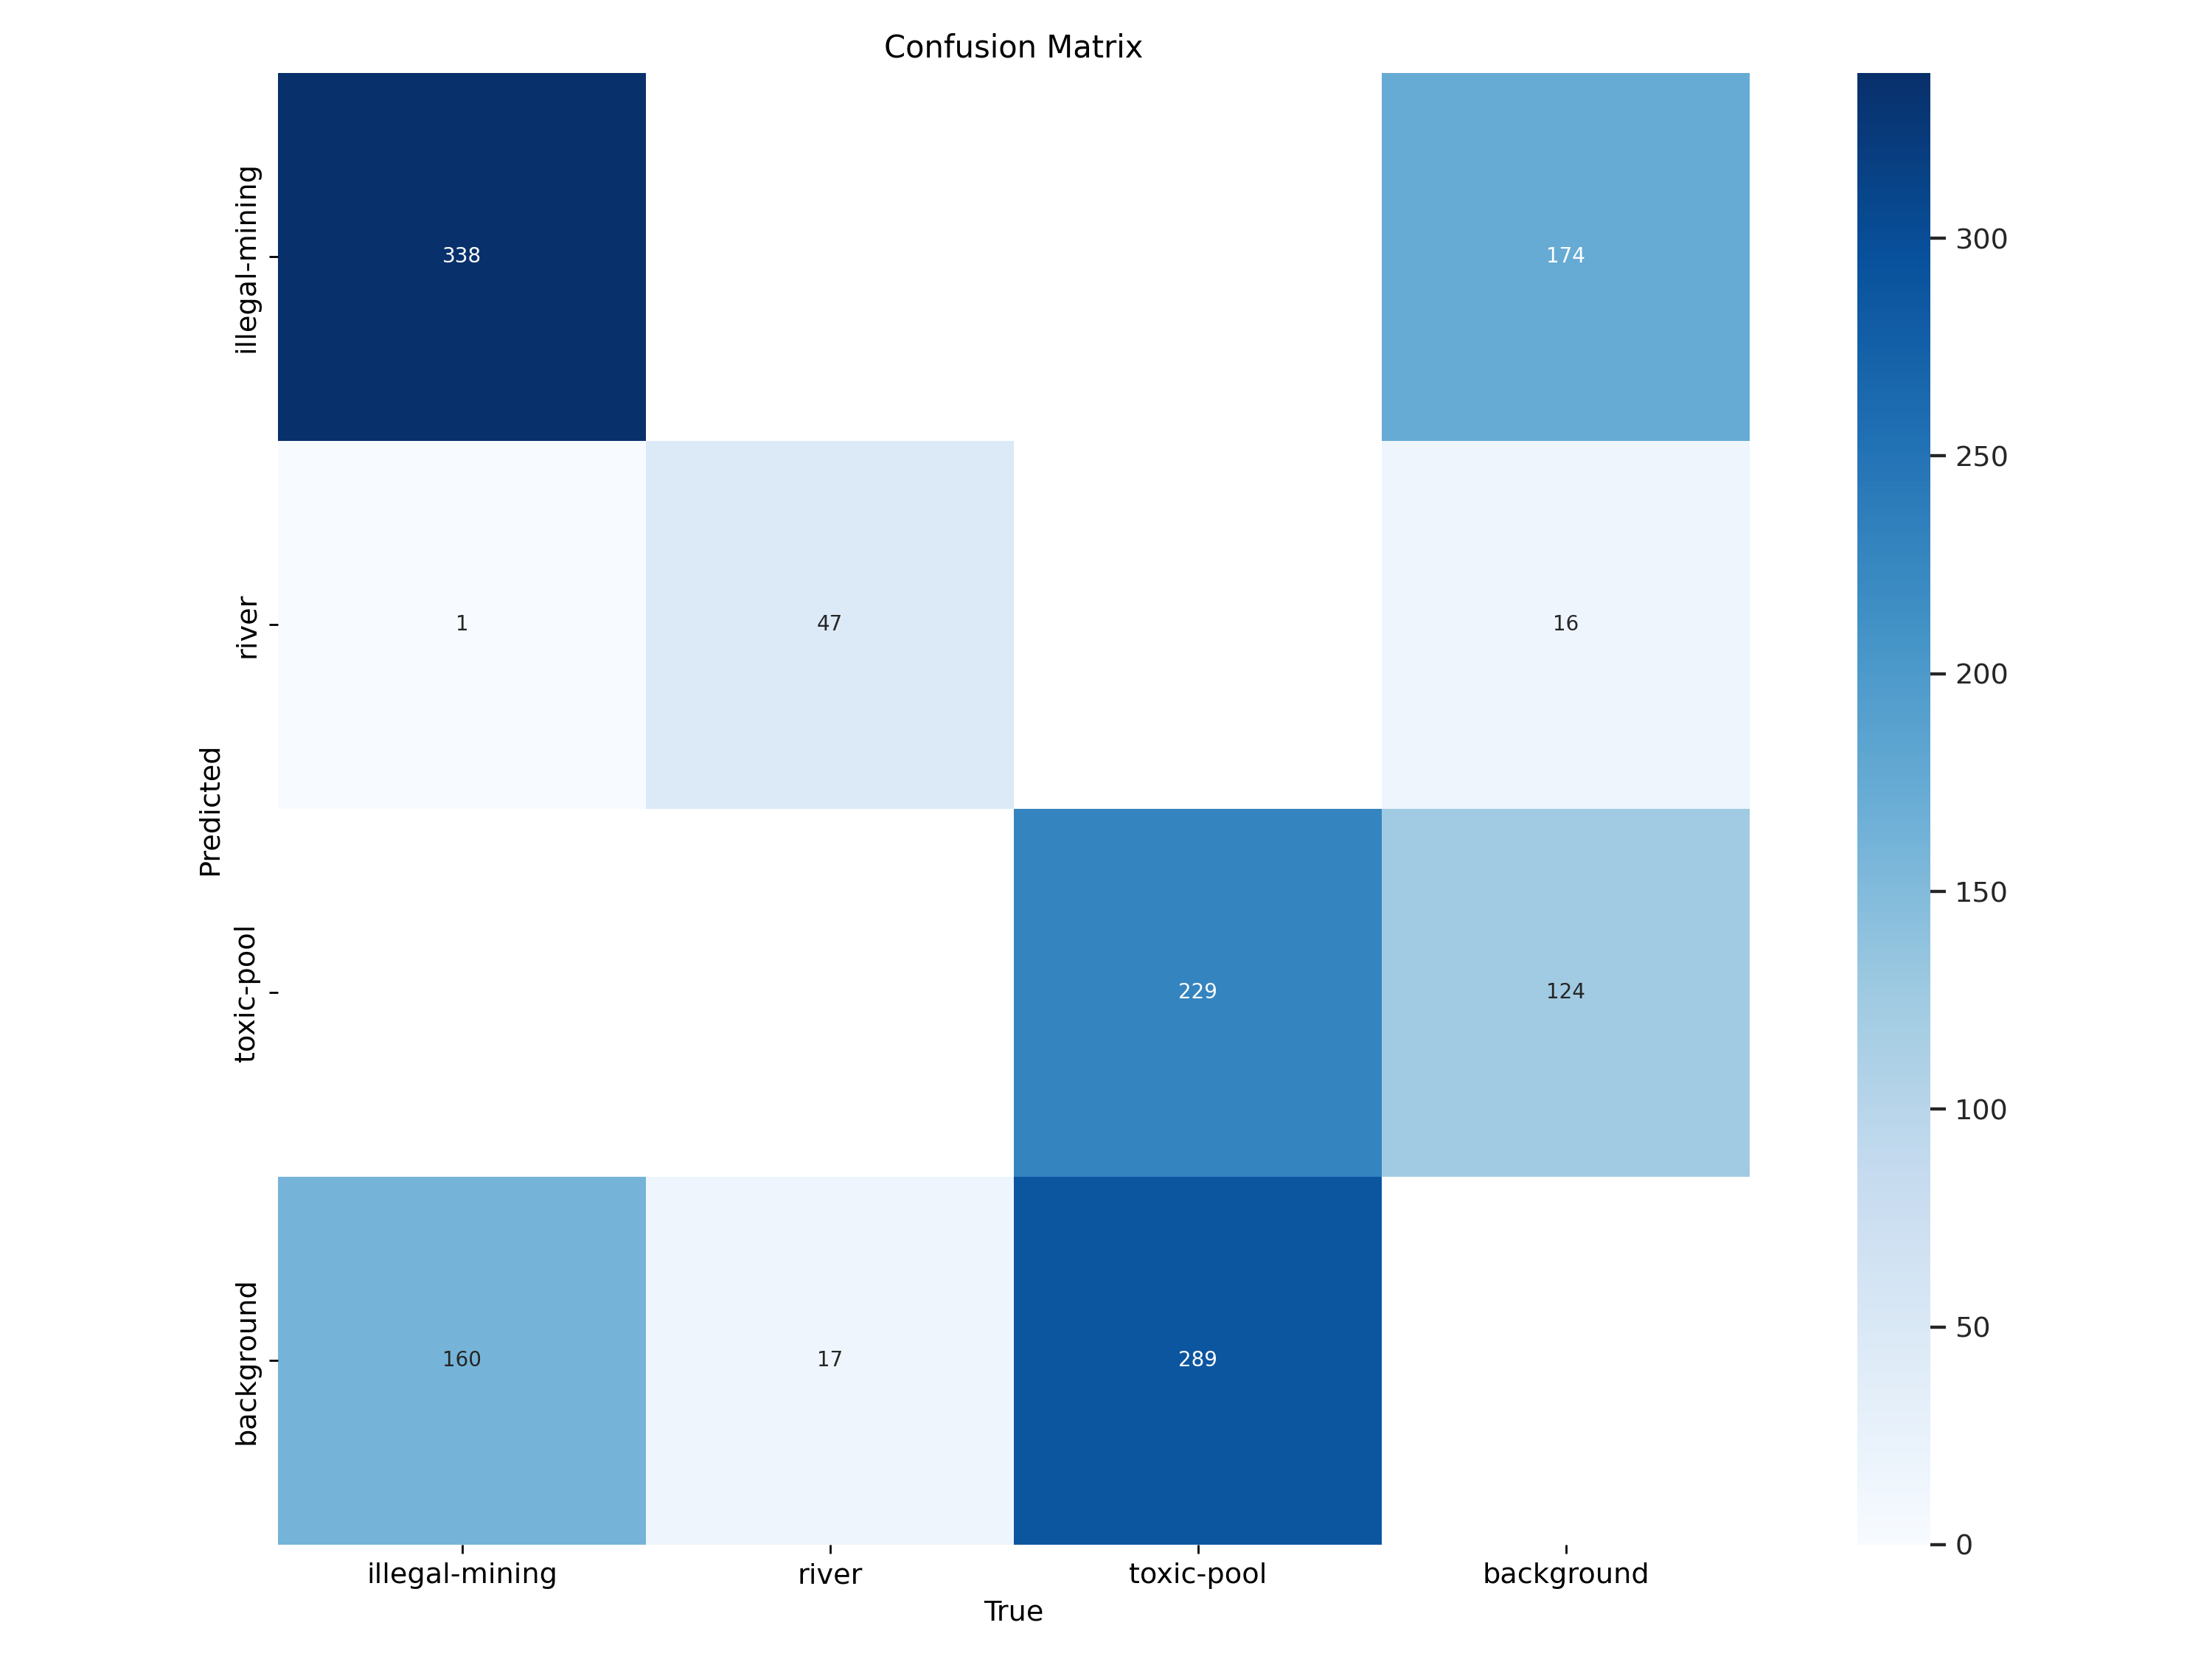

In [7]:
Image(filename=f'/content/runs/segment/train/confusion_matrix.png', width=800)

La matriz de confusión muestra el rendimiento de la de clasificación en cuatro categorías: illegal-mining, river, toxic-pool, y background. Los resultados revelan que illegal-mining tiene un alto número de aciertos (338) pero también muchos errores, especialmente confundido con toxic-pool (229 errores). River tiene menos aciertos (47) y relativamente pocos errores, pero se confunde con background (17 errores). Toxic-pool tiene un número moderado de aciertos (289) y muchos errores, particularmente con illegal-mining (229 errores). Background tiene buenos resultados (289 aciertos), pero se confunde significativamente con illegal-mining (160 errores) y toxic-pool (229 errores). Estos resultados sugieren que el modelo necesita mejorar la distinción entre illegal-mining y toxic-pool, así como una mejor identificación de river frente a background.

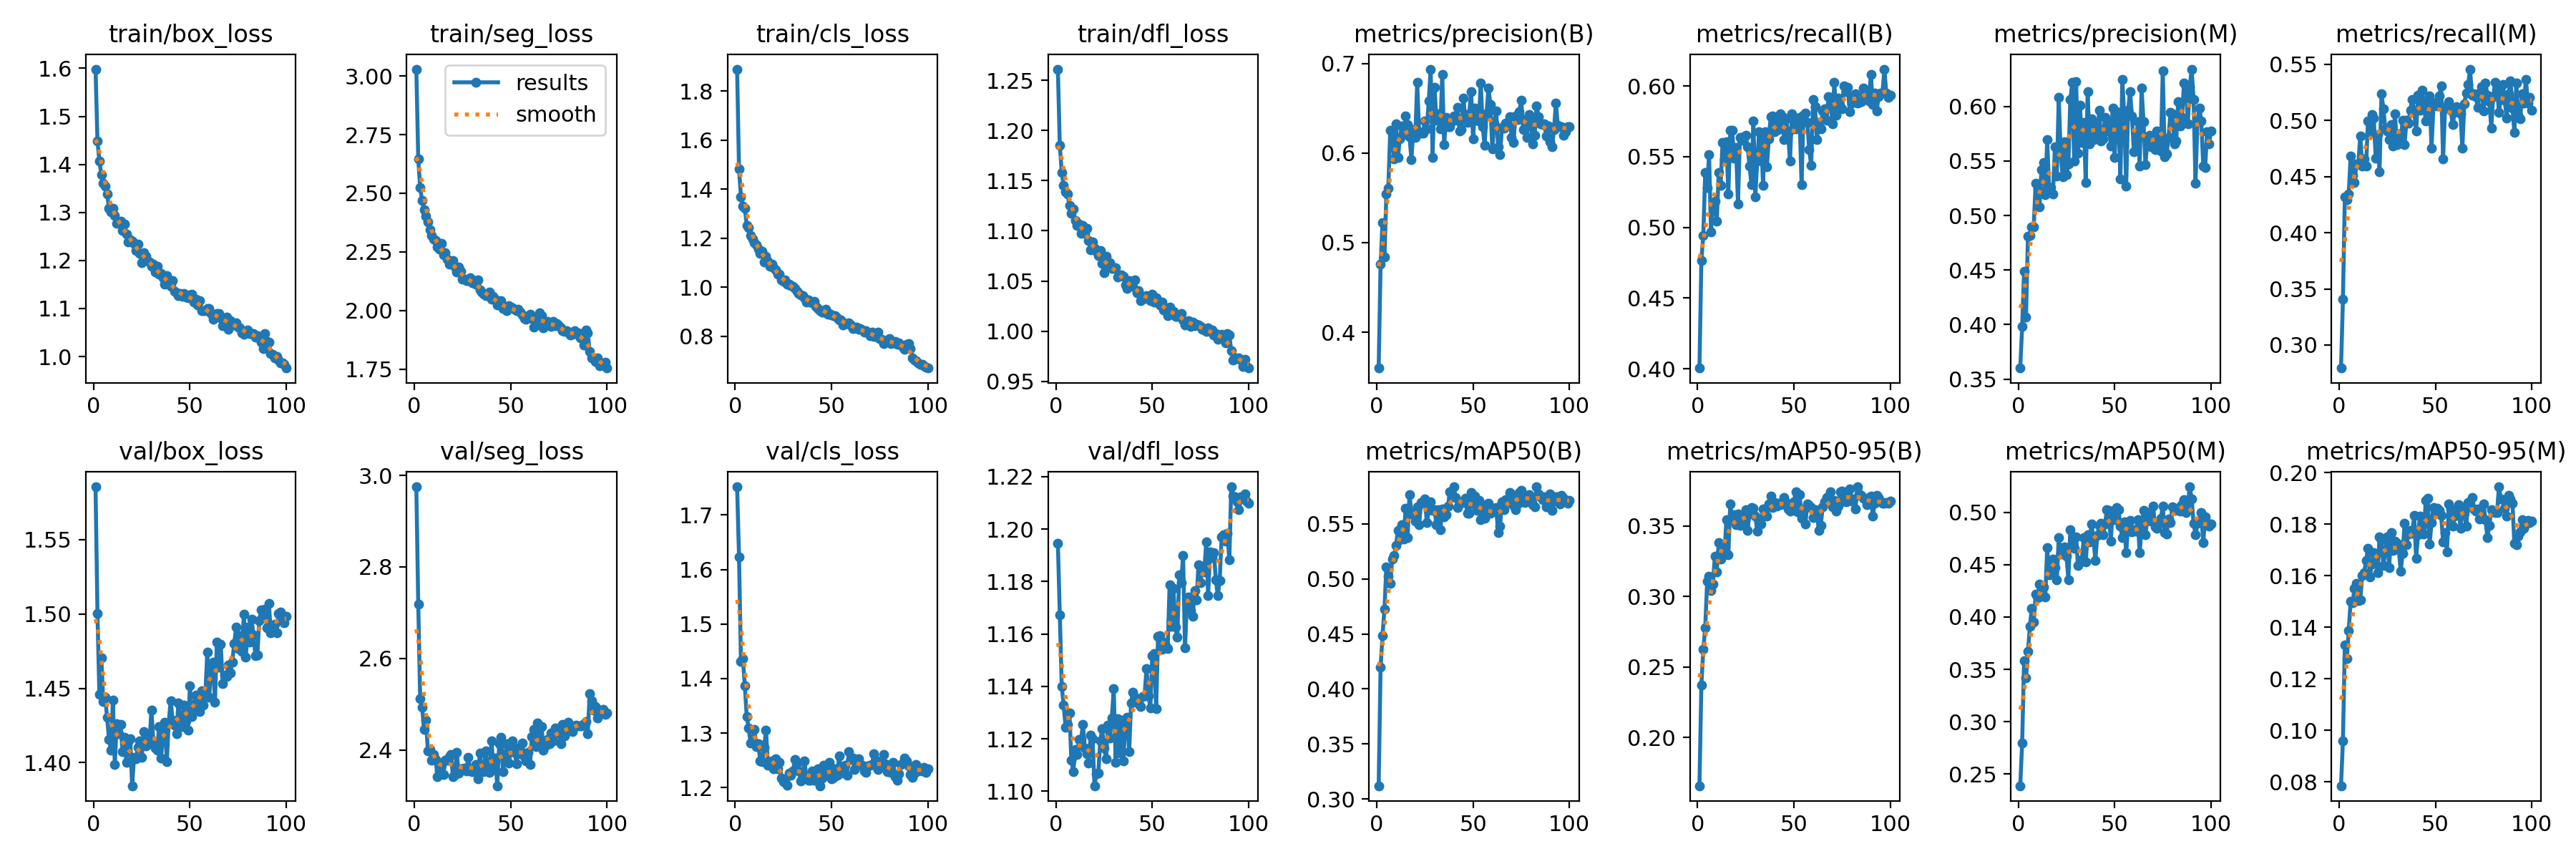

In [8]:
Image(filename=f'/content/runs/segment/train/results.png', width=800)

Las gráficas proporcionadas muestran las métricas de entrenamiento y validación a lo largo de 100 épocas para diferentes aspectos del modelo:

- **box_loss:** Precisa qué tan bien se predicen las cajas
delimitadoras para los objetos.

- **cls_loss:** Mide la precisión de la clasificación de objetos

- **dfl_loss:** Una variante de Focal Loss que ayuda a manejar el desequilibrio de clases y mejorar la detección de objetos poco frecuentes.

- **precision:** Mide la proporción de detecciones correctas.

- **recall:** Mide la proporción de objetos reales detectados.

- **mAP50:** Combina la precisión y el recall para evaluar el rendimiento general en diferentes niveles de confianza y se calcula con un IoU de 0.5.

- **mAP50-95:** Se promedia en un rango de IoU entre 0.5 y 0.95.

1. Las pérdidas de entrenamiento disminuyen constantemente, lo que indica una mejora continua del modelo.

2. Las pérdidas de validación muestran una tendencia a aumentar después de disminuir inicialmente, lo que podría indicar sobreajuste.

3. Las métricas de precisión y recall mejoran y se estabilizan, sugiriendo una mejor identificación y captura de objetos.
Las métricas mAP muestran mejoras constantes y estabilización, indicando una mejora en la precisión de las predicciones del modelo a diferentes umbrales de IoU.

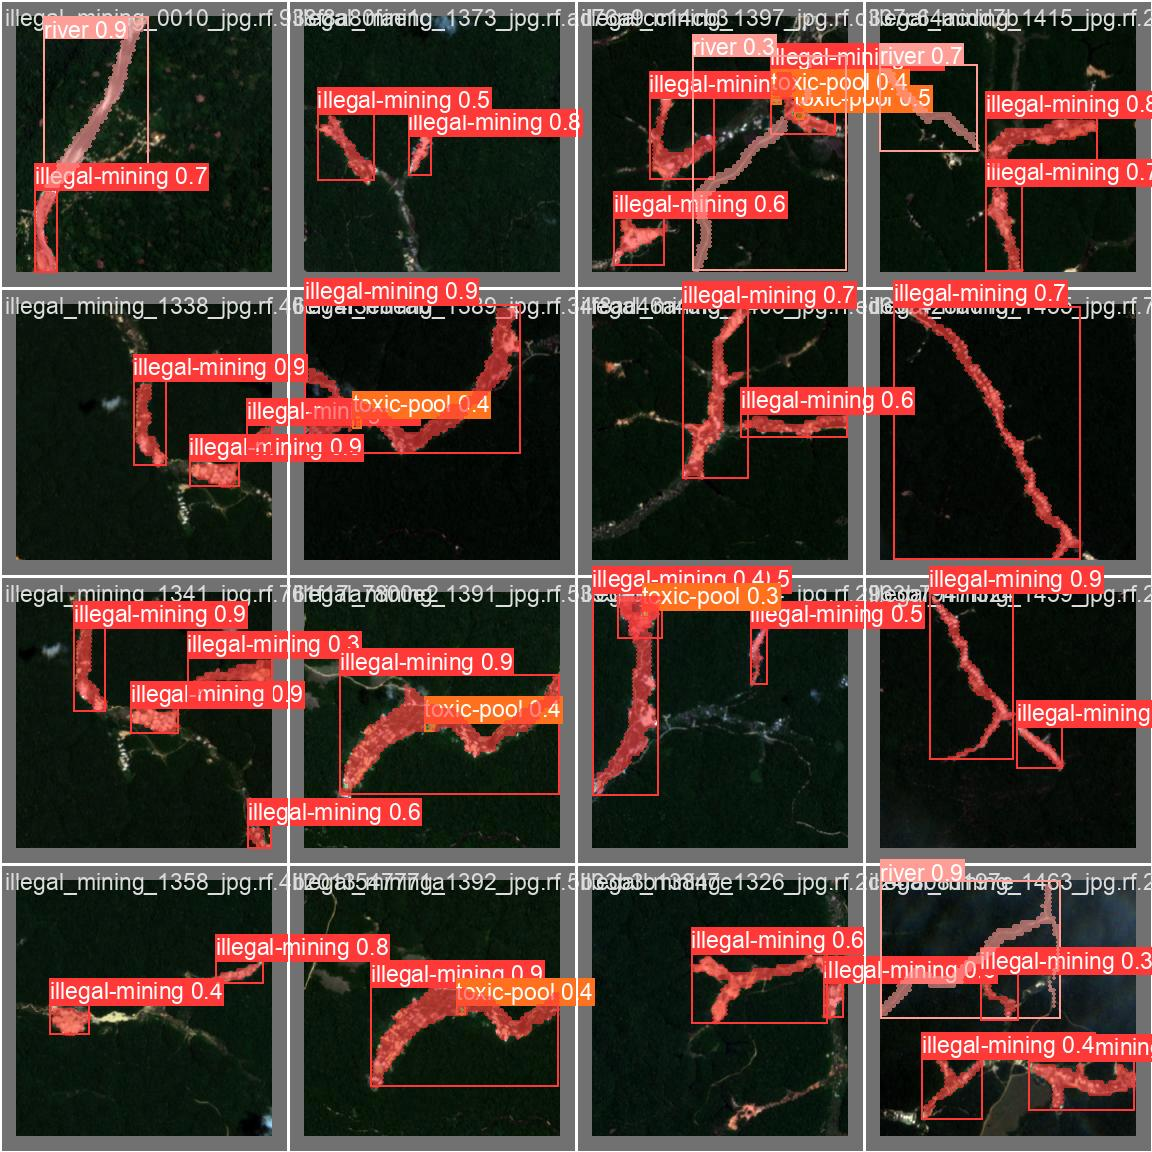

In [9]:
Image(filename=f'/content/runs/segment/train/val_batch0_pred.jpg', width=800)

Para la validacion del modelo podemos ver que en las imagenes se hizo su debida deteccion de minerias ilegales, piscinas toxicas y los rios (si se encontraban en la imagen).

In [10]:
!yolo task=segment mode=val model=/content/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11780761 parameters, 0 gradients, 42.4 GFLOPs
val: Scanning /content/Segmentation-illegal-mining-2/valid/labels.cache... 211 images, 0 backgrounds, 0 corrupt: 100% 211/211 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93% 13/14 [00:06<00:00,  4.14it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 14/14 [00:07<00:0

El modelo de detección y segmentación de instancias tiene un rendimiento general moderado, con un mAP50 de 0.586. Esto significa que, en promedio, el modelo puede detectar y segmentar instancias de objetos con una precisión y un recall aceptables.

Al analizar el desempeño por clase, vemos que el modelo tiene resultados variados:

- Para la clase "illegal-mining", el modelo muestra una precisión de caja (Box(P)) de 0.602 y un mAP50 de 0.594, lo que sugiere que es relativamente bueno en detectar y segmentar instancias de minería ilegal.

- En la clase "river", aunque el mAP50 es más alto (0.716), la precisión de la máscara (Mask(P)) es relativamente baja (0.543), lo que indica que puede haber problemas con la precisión en la segmentación de instancias de ríos.

- La clase "toxic-pool" presenta el mayor desafío para el modelo, con un mAP50 de solo 0.447 y una baja precisión tanto en caja como en máscara. Esto sugiere que el modelo tiene dificultades para detectar y segmentar instancias de piscinas tóxicas.

El modelo tiene un rendimiento general moderado, con un recall de 0.579. Aunque puede detectar más del 50% de las instancias de objetos en las imágenes, aún hay margen para mejorar para lograr un mejor recall. Cabe resaltar que el modelo muestra un buen rendimiento en la detección de minería ilegal y ríos pero enfrenta desafíos significativos en la detección de piscinas tóxicas.

Este bloque de código utiliza el modelo pre-entrenado para realizar predicciones de segmentación de objetos en imágenes de prueba, utilizando un umbral de confianza específico, y guarda las imágenes de salida con las segmentaciones realizadas.

In [11]:
!yolo task=segment mode=predict model=/content/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11780761 parameters, 0 gradients, 42.4 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/104 /content/Segmentation-illegal-mining-2/test/images/illegal_mining_0001_jpg.rf.d9cce286b17cbab521fd2ed9f3f6face.jpg: 256x256 2 rivers, 14.3ms
image 2/104 /content/Segmentation-illegal-mining-2/test/images/illegal_mining_0002_jpg.rf.05b8bfeb7f2b61730f43a2cf791b4920.jpg: 256x256 1 illegal-mining, 1 river, 11.5ms
image 3/104 /content/Segmentation-illegal-mining-2/test/images/illegal_mining_0007_jpg.rf.66402467cfec1231c499ce4f91744bbc.jpg: 256x256 1 illegal-mining, 1 river, 11.2ms
image 4/104 /content/Segmentation-illegal-mining-2/test/images/illegal_mining_0021_jpg.rf.ca9fd057f770ed0b815d77f3444fad66.jpg: 256x256 2 illegal-minings, 1 toxic-pool, 16.3ms
image 5/104 /content/Segmentation-illegal-mining-2/test/images/illegal_mining_0053_jpg.rf.793afe9ee588016b3a01838

Aqui ya podemos verificar como se realizo la deteccion de las distintas clases.

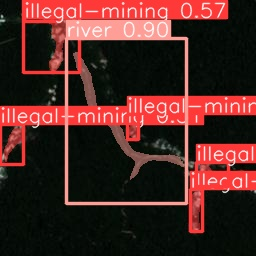

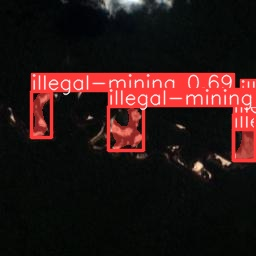

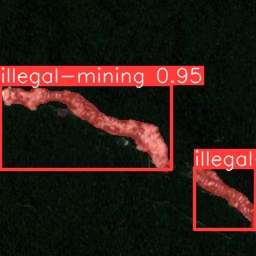

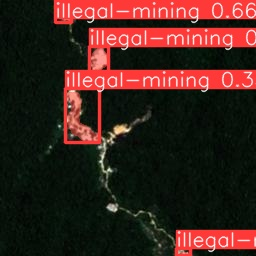

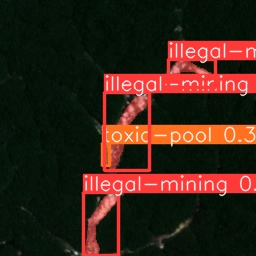

In [12]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/segment/predict/*.jpg')[15:20]:
      display(Image(filename=image_path, width=600))
      print("\n")